In [4]:
import os, sys
sys.path.append('/home/oleg/Prog/Science/ship_tracks_recognition/functions')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from math import *
from Y_views import *
from UV_views import *
%matplotlib inline

In [6]:
all_mctracks = pd.read_csv('Data/MCTrack.csv', delimiter=',')
all_velo_points = pd.read_csv('Data/vetoPoint.csv', delimiter=',')
all_hits = pd.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index

# Creating Learning Table

In [75]:
from ReconstructibleTracks import get_reconstractible_tracks

reconstructible_events = {}

for event_id in range(0, 2500):
    
    tracks = get_reconstractible_tracks(event_id, all_hits, all_mctracks, all_velo_points)
    
    if tracks != []:
        reconstructible_events[event_id] = tracks

/home/oleg/Prog/Science/ship_tracks_recognition/functions/ReconstructibleTracks.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  10000000 * hits.StatNb.values


In [76]:
match_table = {}
for i in all_hits.Index:
        match_table[all_hits.Index[i]] = all_hits.TrackID[i]

In [83]:
table = pd.DataFrame(columns=('event', 'TrackID', 'bef/aft', 'N', 'Max', 'Min', 'deviation', 'Class'))
marks = {}

In [78]:
def dist2Track(point, track):
    return np.abs(- track[0] * point[0] + point[1] - track[1]) / np.sqrt(track[0]**2 + 1.0)

In [84]:
index = 1
for i in reconstructible_events:
    event = modify_for_yz_analysis_1_2(all_hits[all_hits['event'] == i])
    tracks_yz_1_2, linking_table_yz_1_2 = loop_yz(event, 7, 0.85, 0)
    for k in tracks_yz_1_2:
        N = len(linking_table_yz_1_2[k])
        dists = [dist2Track((event.Wz[j], event.Wy[j]), tracks_yz_1_2[k]) / event.dist2Wire[j] for j in linking_table_yz_1_2[k]]
        arr = [match_table[j] for j in linking_table_yz_1_2[k]]
        Max = np.max(dists)
        Min = np.min(dists)
        deviation = np.average(dists)
        _, counts = np.unique(arr, return_counts = True)
        cl = np.max(counts) / len(linking_table_yz_1_2[k])
        table.loc[index] = [i, k, 0, N, Max, Min, deviation, cl]
        index += 1
    event = modify_for_yz_analysis_3_4(all_hits[all_hits['event'] == i])
    tracks_yz_3_4, linking_table_yz_3_4 = loop_yz(event, 7, 0.85, 1)
    for k in tracks_yz_3_4:
        N = len(linking_table_yz_3_4[k])
        dists = [dist2Track((event.Wz[j], event.Wy[j]), tracks_yz_3_4[k]) / event.dist2Wire[j] for j in linking_table_yz_3_4[k]]
        arr = [match_table[j] for j in linking_table_yz_3_4[k]]
        Max = np.max(dists)
        Min = np.min(dists)
        deviation = np.average(dists)
        _, counts = np.unique(arr, return_counts = True)
        cl = np.max(counts) / len(linking_table_yz_3_4[k])
        table.loc[index] = [i, k, 1, N, Max, Min, deviation, cl]
        index += 1

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [88]:
table.head()

,Unnamed: 0,event,TrackID,bef/aft,N,Max,Min,deviation,Class
0,1,513,1,0,8,1.215309,0.759074,1.007472,1
1,2,513,2,0,8,1.039541,0.965492,1.000407,1
2,3,513,1,1,9,1.206719,0.026863,0.907816,1
3,4,513,2,1,8,1.143564,0.227930,0.833862,1
4,5,2,1,0,9,1.034219,0.279639,0.898669,1


In [86]:
table.to_csv('./Data/TracksTable.csv')

# Show efficiency of classifier

In [7]:
table = pd.read_csv('./Data/TracksTable.csv')

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

In [9]:
clf = RandomForestClassifier(n_estimators=100, class_weight='auto')

In [10]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(table[['N', 'Max', 'Min', 'deviation']], table['Class'], test_size = 0.4)

In [11]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
clf.score(X_test, y_test)

0.97211155378486058

# Decision Scores

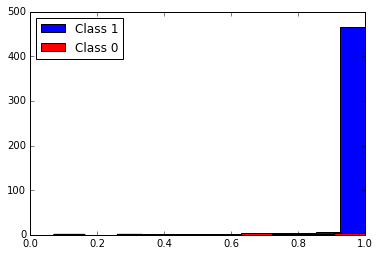

In [13]:
plt.hist(clf.predict_proba(X_test[y_test==1]).T[1], color="blue", label="Class 1")
plt.hist(clf.predict_proba(X_test[y_test==0]).T[1], color="red", label="Class 0")
plt.legend(loc="upper left")

# 2D plots of paired features

Class 0- red
Class 1- blue


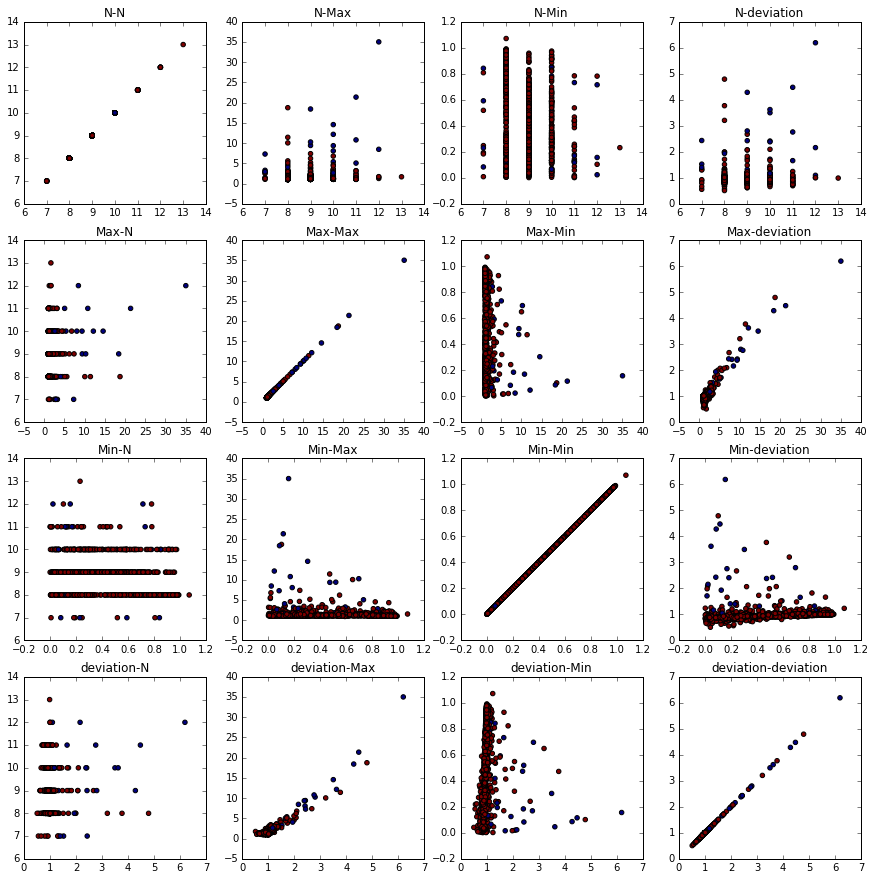

In [14]:
features = ('N', 'Max', 'Min', 'deviation')
plt.figure(figsize=(15, 15))
k = 1
for i in features:
    for j in features:
        plt.subplot(4, 4, k)
        k += 1
        plt.scatter(table[i], table[j], c=table['Class'])
        plt.title(i+'-'+j)
print "Class 0- red"
print "Class 1- blue"

# Histograms of the features

Class 0- red
Class 1- blue


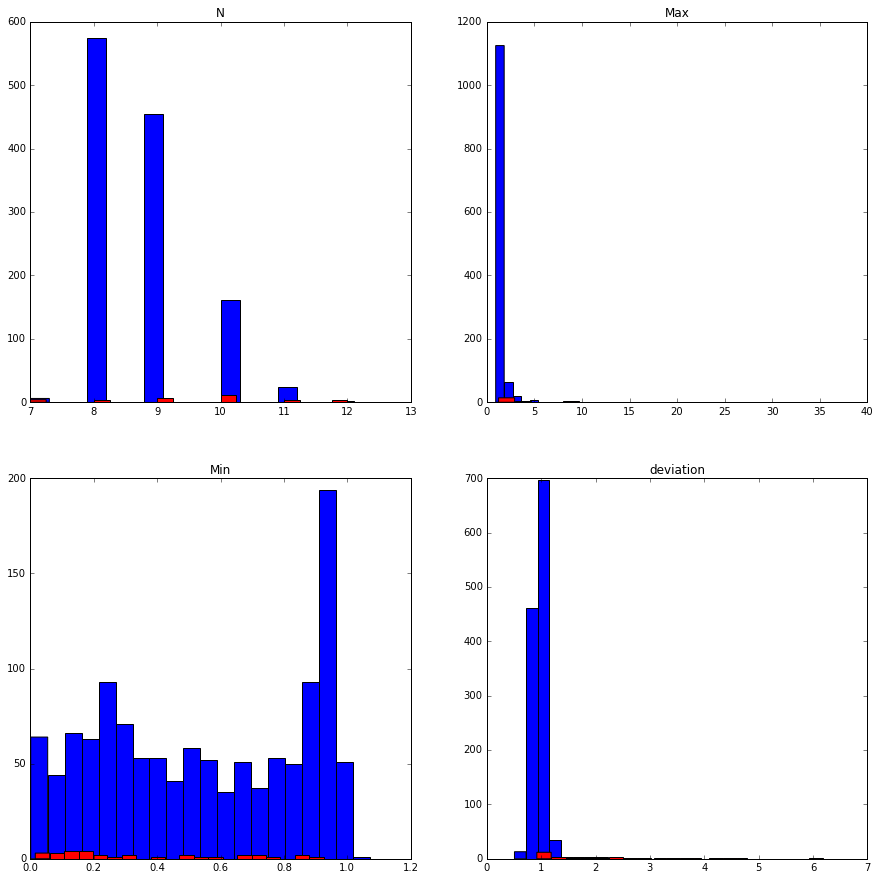

In [15]:
plt.figure(figsize=(15, 15))
k = 1
for i in features:
    plt.subplot(2, 2, k)
    k += 1
    plt.hist(table[i][table.Class==1].reset_index(drop=True), color='blue', bins=20)
    plt.hist(table[i][table.Class==0].reset_index(drop=True), color='red', bins=20)
    plt.title(i)
print "Class 0- red"
print "Class 1- blue"

# Metrics

In [16]:
#all metrics were calculated with option pos_label = 0 (classes are swapped)

# ROC

In [17]:
from sklearn import metrics

In [18]:
y_score = clf.predict_proba(X_test)

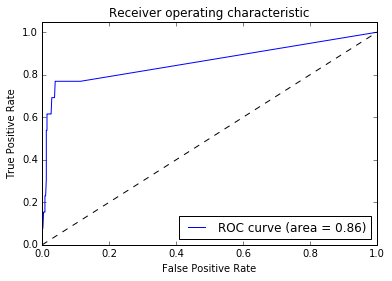

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,0], pos_label=0)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Recall

In [20]:
metrics.recall_score(y_test, clf.predict(X_test), pos_label=0)

0.15384615384615385

# Precision

In [21]:
metrics.precision_score(y_test, clf.predict(X_test), pos_label=0)

0.40000000000000002

# Examples of events with low efficiency

In [45]:
def picture(event, ind):
    plane_width = 0.85
    n_min = 7
    tracks, linking_table = loop_yz(event, n_min, plane_width, ind)
    crossing_points = linking_table
    
    event = modify_for_yz_analysis_1_2(event)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1, 1, 1)
    
    original_tracks = set(event.TrackID)
    if -2 in original_tracks:
        original_tracks.remove(-2)

    for j in original_tracks:
        track = event[event.TrackID==j]
        Wz = track.Wz.values
        Wy = track.Wy.values
        Z = track.Z.values
        Y = track.Y.values
        R = track.dist2Wire.values
        StrwR = 0.5 * np.ones(shape=(Z.shape[0],))

        # originl track and hits
        plt.plot(Z, Y, c='r', label='original track '+str(j))
        plt.scatter(Z, Y, c='r', label='original hits')

        # The wire centers and dist2wire
        plt.scatter(Wz, Wy, c='b', label='wire centers')
        for index in range(0, Z.shape[0]):
            circ = plt.Circle((Wz[index], Wy[index]), radius=R[index], color='b', fill=False)
            ax.add_patch(circ)

    for j in tracks:
        # crossing point
        Z_crossing = np.array([event.loc[i].Wz for i in crossing_points[j]])
        Y_crossing = np.array([event.loc[i].Wy for i in crossing_points[j]])
        Y_line_crossing = Z_crossing * tracks[j][0] + tracks[j][1]

        plt.scatter(Z_crossing, Y_crossing, c='gold', label='crossing points', s=50)
        plt.plot(Z_crossing, Y_line_crossing , c='gold', label='crossing track '+str(j))



    plt.legend(loc='best')
    plt.show()

In [23]:
table[table.Class==0]

,Unnamed: 0,event,TrackID,bef/aft,N,Max,Min,deviation,Class
26,27,7,1,1,12,35.033507,0.156232,6.193331,0
35,36,1036,1,0,10,3.229657,0.194631,1.407867,0
67,68,27,1,0,10,5.389423,0.015593,1.714079,0
68,69,27,2,0,7,2.834492,0.842329,1.322691,0
103,104,558,2,0,9,3.653798,0.418477,1.320158,0
150,151,1090,1,0,10,8.071062,0.183980,2.413192,0
418,419,1704,1,1,9,9.412105,0.519238,2.426612,0
450,451,184,1,1,10,1.652939,0.782516,1.116232,0
452,453,1722,1,0,10,9.362538,0.473632,2.383530,0
465,466,2239,1,1,9,10.272360,0.696425,2.800949,0


In [43]:
event_id = 27
event = all_hits[all_hits['event'] == event_id]
event = modify_for_yz_analysis_1_2(event)
event

,Unnamed: 0,Unnamed: 0.1,Bits,TrackID,Px,Py,Pz,Time,Length,ELoss,...,event,k,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Index,Wy,Wz
3420,3420,3420,33554432,2,0.506768,0.068706,32.412354,383.907318,0.510836,2.823857e-06,...,27,35,1,0,0,0,311,3420,-46.6514,2581.15
3385,3385,3385,33554432,3,-0.364015,-0.348315,35.865162,383.940033,0.751938,2.586669e-06,...,27,0,1,0,0,1,312,3385,-47.5314,2582.25
3421,3421,3421,33554432,2,0.507201,0.068788,32.412304,383.947815,0.278159,1.793916e-06,...,27,36,1,0,0,1,312,3421,-47.5314,2582.25
3386,3386,3386,33554432,3,-0.363989,-0.348006,35.865147,383.986938,0.931124,3.301072e-06,...,27,1,1,0,1,0,311,3386,-47.0914,2583.75
3422,3422,3422,33554432,2,0.507475,0.068531,32.412266,383.986298,0.973040,3.470375e-06,...,27,37,1,0,1,0,311,3422,-47.0914,2583.75
3427,3427,3427,33554432,2,0.507166,0.066513,32.412174,384.905426,0.672471,2.501201e-06,...,27,42,1,3,0,0,311,3427,-46.6514,2611.15
3391,3391,3391,33554432,3,-0.364227,-0.345896,35.865002,384.937042,0.974006,2.919081e-06,...,27,6,1,3,0,1,312,3391,-47.5314,2612.25
3392,3392,3392,33554432,3,-0.363710,-0.345494,35.864986,384.995789,0.443074,2.077574e-07,...,27,7,1,3,1,0,311,3392,-47.0914,2613.75
3428,3428,3428,33554432,2,0.507091,0.066439,32.412159,384.987396,0.957235,4.124390e-06,...,27,43,1,3,1,0,311,3428,-47.0914,2613.75
3393,3393,3393,33554432,3,-0.363652,-0.345597,35.864952,385.032837,0.438834,6.918509e-07,...,27,8,1,3,1,1,312,3393,-47.9714,2614.85


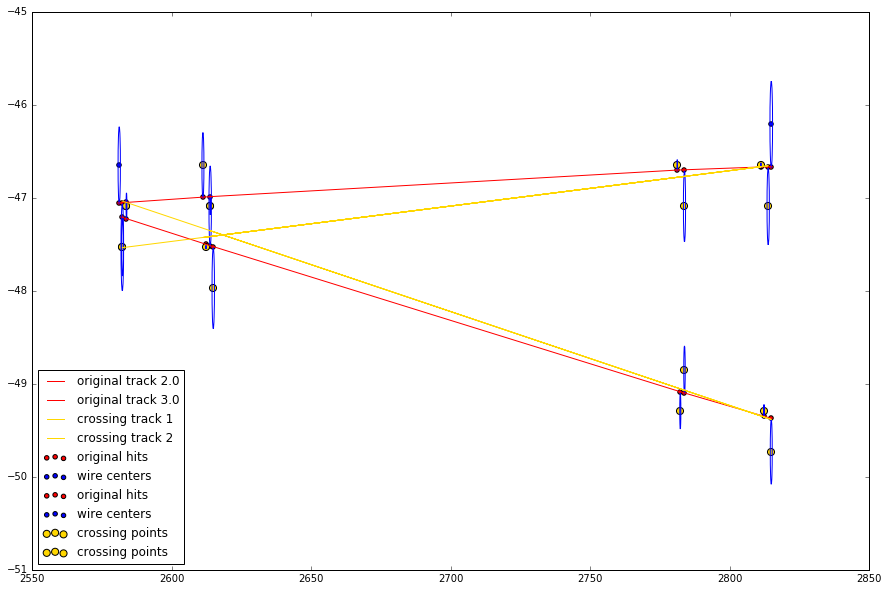

In [46]:
picture(event, 0)

In [47]:
event_id = 1533
event = all_hits[all_hits['event'] == event_id]
event = modify_for_yz_analysis_1_2(event)
event

,Unnamed: 0,Unnamed: 0.1,Bits,TrackID,Px,Py,Pz,Time,Length,ELoss,...,event,k,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Index,Wy,Wz
63725,63725,63725,33554432,2,0.717190,0.279212,31.428078,383.913452,0.959449,1.357837e-06,...,1533,36,1,0,0,0,284,63725,0.8686,2581.15
63689,63689,63689,33554432,3,0.005185,-0.276827,39.177643,383.949371,0.971955,8.430991e-06,...,1533,0,1,0,0,1,285,63689,-0.0114,2582.25
63690,63690,63690,33554432,3,0.005403,-0.276315,39.177380,384.042419,0.599313,3.280410e-06,...,1533,1,1,0,1,1,285,63690,-0.4514,2584.85
63726,63726,63726,33554432,2,0.717201,0.279313,31.428057,384.040771,0.735214,2.884626e-06,...,1533,37,1,0,1,1,284,63726,1.3086,2584.85
63731,63731,63731,33554432,2,0.716971,0.281243,31.427633,384.919220,0.669052,3.607152e-06,...,1533,42,1,3,0,0,284,63731,0.8686,2611.15
63695,63695,63695,33554432,3,0.005999,-0.278033,39.177261,384.952271,0.837260,3.658851e-06,...,1533,6,1,3,0,1,285,63695,-0.0114,2612.25
63696,63696,63696,33554432,3,0.006247,-0.278581,39.177242,385.037872,0.912169,3.210794e-06,...,1533,7,1,3,1,1,285,63696,-0.4514,2614.85
63732,63732,63732,33554432,2,0.716910,0.281342,31.427616,385.037781,0.969435,4.085958e-06,...,1533,43,1,3,1,1,284,63732,1.3086,2614.85
63733,63733,63733,33554432,2,0.716771,0.307057,31.427362,390.587616,0.909499,1.183310e-05,...,1533,44,2,0,0,0,283,63733,2.6286,2781.15
63766,63766,63766,33554432,-2,0.000215,-0.002383,-0.003691,391.846985,0.939809,2.279419e-06,...,1533,77,2,0,0,0,300,63766,-27.2914,2781.15


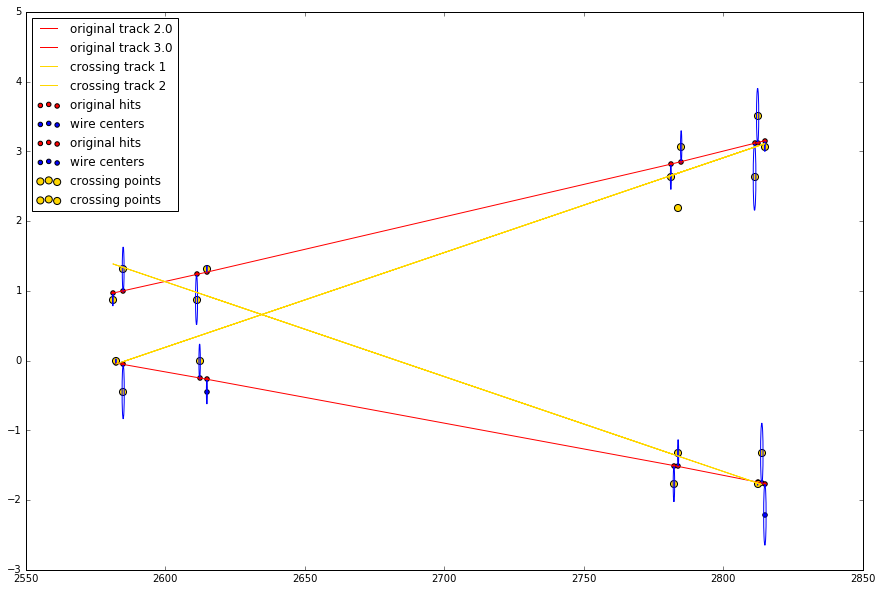

In [48]:
picture(event, 0)

In [49]:
event_id = 970
event = all_hits[all_hits['event'] == event_id]
event = modify_for_yz_analysis_1_2(event)
event

,Unnamed: 0,Unnamed: 0.1,Bits,TrackID,Px,Py,Pz,Time,Length,ELoss,...,event,k,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Index,Wy,Wz
37376,37376,37376,33554432,3,0.692779,0.007972,17.495743,384.005981,0.656757,0.000003,...,970,0,1,0,0,0,275,37376,16.7086,2581.15
37413,37413,37413,33554432,2,-0.127237,0.066364,27.165863,384.009247,0.803295,0.000002,...,970,37,1,0,0,1,273,37413,21.1086,2582.25
37377,37377,37377,33554432,3,0.692812,0.008069,17.495712,384.087677,0.962054,0.000004,...,970,1,1,0,1,0,275,37377,16.2686,2583.75
37414,37414,37414,33554432,2,-0.126968,0.066352,27.165850,384.094116,0.913442,0.000004,...,970,38,1,0,1,1,273,37414,20.6686,2584.85
37382,37382,37382,33554432,3,0.693612,0.010224,17.495575,385.006897,0.690213,0.000006,...,970,6,1,3,0,0,275,37382,16.7086,2611.15
37420,37420,37420,33554432,2,-0.126926,0.063873,27.165684,385.008606,0.885181,0.000003,...,970,44,1,3,0,1,273,37420,21.1086,2612.25
37383,37383,37383,33554432,3,0.693973,0.010354,17.495522,385.089264,0.956000,0.000008,...,970,7,1,3,1,0,275,37383,16.2686,2613.75
37421,37421,37421,33554432,2,-0.126620,0.063608,27.165670,385.095947,0.846273,0.000008,...,970,45,1,3,1,1,273,37421,20.6686,2614.85
37384,37384,37384,33554432,3,0.694204,0.035973,17.495455,390.677979,0.936313,0.000002,...,970,8,2,0,0,0,275,37384,16.7086,2781.15
37422,37422,37422,33554432,2,-0.126774,0.037551,27.165695,390.678375,0.942576,0.000003,...,970,46,2,0,0,1,273,37422,21.1086,2782.25


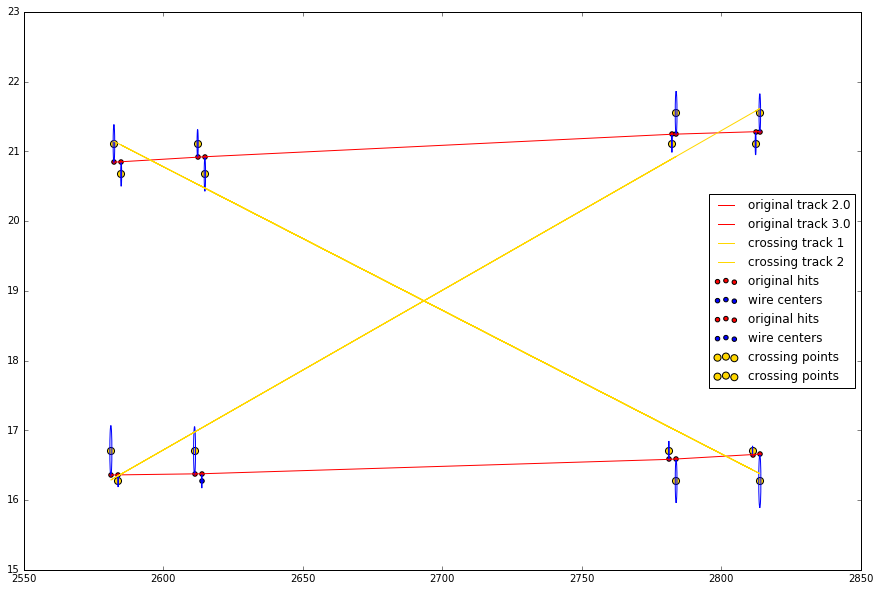

In [50]:
picture(event, 0)